# Mood-Based  Content Recommendation System for Chilio

## Problem Statement

Chilio's queer content is underperforming due to a content discovery and mood-matching issue. Users frequently select titles expecting one emotional tone (e.g., light and humorous) but encounter content with a dramatically different mood (e.g., intense and emotionally draining). This mismatch leads to poor viewing experiences, reduced engagement, and lower viewership for queer content on the platform.

## Business Objective

1. How can we match users with queer content that fits their current mood?

2. How can we personalize queer content recommendations in a way that enhances emotional connection and user satisfaction?

3. How can we use mood as a recommendation input to complement traditional filters like genre or rating?


## Project Flow
1. Understand the problem import libraries, load the data

2. Data Preprocessing 
    - Create a function that goes through the Movie Overview and a sign an emotion to. The emotions is housed in a seperate column
    - Feature Engineering 
    - Outlier Treatment 
    - Missing Value Treatment

3. Split the data 
    - Divide data into training(70%) and testing (30%)

4. Data Modeling 
    - Choose Model - Decision Trees
    - Train Model 
        - Feed training data into model
        - Adjust internal Parameters
    - Evaluate Model
        - F1 score to measure how well the model performs

5. Model Validation
    - Fine Tune Model
 


## 1. Import Libraries and Load Dataset

Because the project is about creating a mood based recommendation system NRCLEX is installed to help in creating a column to house the emotion of the each movie based on the Movie overview

In [1]:
#Import needed Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
#%pip install NRCLex
from nrclex import NRCLex
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
#Load dataset

data = pd.read_csv('lgbtq_movies.csv')

data.head()


,id,title,original_title,original_language,overview,release_date,popularity,vote_average,vote_count,adult,video,genre_ids
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,2022-04-29,321.755,7.5,120,False,False,"[35, 10749]"
1,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",2020-12-11,139.229,7.1,26,False,False,"[16, 18, 10749]"
2,632632,Given,映画 ギヴン,ja,The film centers on the love relationship amon...,2020-08-22,110.140,8.4,318,False,False,"[16, 18, 10402, 10749]"
3,929477,Heart Shot,Heart Shot,en,Teenagers Nikki and Sam are in love and planni...,2022-02-17,88.760,5.4,37,False,False,"[10749, 80]"
4,197158,Porno,Pornô!,pt,Three tales of the erotic: Two young ladies ex...,1981-01-01,76.302,4.3,46,False,False,[18]


## 2. Data Preprocessing

This step is important in the project as it will in removing data that would hinder our outcome such as missing overviews or null values, it is also needed to deal with categorical data and detect outliers


In [3]:
#Check for missing values
data.isnull().sum()

id                    0
title                 0
original_title        0
original_language     0
overview             77
release_date         90
popularity            0
vote_average          0
vote_count            0
adult                 0
video                 0
genre_ids             0
dtype: int64

In [4]:
#Understand the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7165 non-null   int64  
 1   title              7165 non-null   object 
 2   original_title     7165 non-null   object 
 3   original_language  7165 non-null   object 
 4   overview           7088 non-null   object 
 5   release_date       7075 non-null   object 
 6   popularity         7165 non-null   float64
 7   vote_average       7165 non-null   float64
 8   vote_count         7165 non-null   int64  
 9   adult              7165 non-null   bool   
 10  video              7165 non-null   bool   
 11  genre_ids          7165 non-null   object 
dtypes: bool(2), float64(2), int64(2), object(6)
memory usage: 573.9+ KB


In [5]:
#Change release_date to release_year 

data['release_year'] = pd.to_datetime(data['release_date']).dt.year.fillna(0).astype(int)
data['release_year'].tail()

7160    2010
7161       0
7162    2001
7163    2022
7164    2022
Name: release_year, dtype: int64

In [6]:
#Drop release_date column as it is not longer needed
data.drop(columns=['release_date'], inplace=True)

In [7]:
#Drop unnecessary columns
data.drop(columns=['vote_count', 'adult', 'video'],inplace=True)

In [8]:
#Load genres data
genre = pd.read_csv('movies_genres.csv')
genre

,genre_ids,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [9]:
# Convert genre_ids from string representation of list to actual list if needed
if isinstance(data['genre_ids'].iloc[0], str):
	import ast
	data['genre_ids'] = data['genre_ids'].apply(ast.literal_eval)

# Explode genre_ids so each row has a single genre id
data_exploded = data.explode('genre_ids')

# Drop rows where genre_ids is NaN before converting to int
data_exploded = data_exploded.dropna(subset=['genre_ids'])
data_exploded['genre_ids'] = data_exploded['genre_ids'].astype(int)

# Merge with genre DataFrame
content = pd.merge(data_exploded, genre, on='genre_ids', how='left')
content

,id,title,original_title,original_language,overview,popularity,vote_average,genre_ids,release_year,name
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,35,2022,Comedy
1,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,10749,2022,Romance
2,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,16,2020,Animation
3,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,18,2020,Drama
4,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,10749,2020,Romance
...,...,...,...,...,...,...,...,...,...,...
8301,37889,Flex Appeal,Flex Appeal,en,Ron Williams' latest foray into the beauty of ...,0.600,0.0,99,2003,Documentary
8302,983153,God,dEUs,pt,Gustavo is a young adult attending law school....,0.000,0.0,18,0,Drama
8303,983027,To My Star 2: Our Untold Stories,나의 별에게2 : 우리의 못다 한 이야기,ko,After his career took a steady turn for the wo...,0.000,0.0,18,2022,Drama
8304,983027,To My Star 2: Our Untold Stories,나의 별에게2 : 우리의 못다 한 이야기,ko,After his career took a steady turn for the wo...,0.000,0.0,10749,2022,Romance


In [10]:
#Rename genre column to genre_name
content.rename(columns={'name': 'genre_name'}, inplace=True)
content.head()

,id,title,original_title,original_language,overview,popularity,vote_average,genre_ids,release_year,genre_name
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,35,2022,Comedy
1,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,10749,2022,Romance
2,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,16,2020,Animation
3,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,18,2020,Drama
4,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,10749,2020,Romance


In [11]:
#Installed TextBlob for sentiment analysis after error with nltk
#%pip install --upgrade textblob

from textblob import download_corpora
download_corpora.download_all()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already u

In [12]:
#Create a function to get emotions from text using NRCLex and filter out emotion scores of 0
def get_emotions(text):
    if pd.isna(text):
        return 'None'
    emotions = NRCLex(str(text))
    emotions_scores = emotions.affect_frequencies
    if isinstance(emotions_scores, dict):
        filtered_emotions = {emotion: score for emotion, score in emotions_scores.items() if score > 0}
        if filtered_emotions:
            return max(filtered_emotions, key=filtered_emotions.get)
        else:
            return 'None'
    else:
        return 'None'

content['emotions'] = content['overview'].apply(get_emotions)
content['emotions'].head()

0    positive
1    positive
2       trust
3       trust
4       trust
Name: emotions, dtype: object

In [13]:
#Combine duplicates by genre_name and id 
content = content.groupby('id').agg({
    'title' : 'first',
    'original_title' : 'first',
    'original_language' : 'first',
    'overview' : 'first',
    'popularity' : 'first',
    'release_year' : 'first',
    'vote_average' : 'first',
    'popularity' : 'first',
    'emotions' : lambda x: ','.join(x.unique()),
    'genre_name' : lambda x: ','.join(x.unique()),
    'genre_ids' : lambda x: ','.join(map(str, x.unique()))   
})
content.reset_index(inplace=True)
content.head(20)

,id,title,original_title,original_language,overview,popularity,release_year,vote_average,emotions,genre_name,genre_ids
0,14,American Beauty,American Beauty,en,"Lester Burnham, a depressed suburban father in...",32.508,1999,8.0,trust,Drama,18
1,26,Walk on Water,LaLehet Al HaMayim,he,"Eyal, an Israeli Mossad agent, is given the mi...",4.800,2004,6.9,positive,Drama,18
2,71,Billy Elliot,Billy Elliot,en,Set against the background of the 1984 Miners'...,19.989,2000,7.6,anger,"Drama,Comedy,Music","18,35,10402"
3,142,Brokeback Mountain,Brokeback Mountain,en,Two modern-day cowboys meet on a shepherding j...,31.967,2005,7.8,positive,"Drama,Romance","18,10749"
4,226,Boys Don't Cry,Boys Don't Cry,en,A young transgender man explores his gender id...,12.260,1999,7.5,positive,"Crime,Drama","80,18"
5,294,Desert Hearts,Desert Hearts,en,The story of straight-edge literature professo...,8.737,1985,7.1,positive,"Drama,Romance","18,10749"
6,321,Mambo Italiano,Mambo Italiano,en,"When an Italian man comes out of the closet, i...",4.966,2003,5.8,fear,"Comedy,Romance","35,10749"
7,340,Everything Is Illuminated,Everything Is Illuminated,en,A young Jewish American man endeavors—with the...,8.381,2005,7.3,positive,"Comedy,Drama","35,18"
8,342,Summer Storm,Sommersturm,de,"Tobi and Achim, the pride of the local crew cl...",9.686,2004,6.8,trust,"Comedy,Drama","35,18"
9,349,Cockles and Muscles,Crustacés et coquillages,fr,Crustacés et coquillages is a fresh French com...,3.138,2005,6.2,positive,Comedy,35


In [14]:
#Added more libraries to help with breaking down the overview text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re

In [15]:
content['overview_length'] = content['overview'].str.len()
content['word_count'] = content['overview'].str.split().str.len()
content['excalamation_count'] = content['overview'].str.count('!')
content['overview_length'] = content['overview'].str.count('\?')



<>:4: SyntaxWarning: invalid escape sequence '\?'
<>:4: SyntaxWarning: invalid escape sequence '\?'
C:\Users\USER\AppData\Local\Temp\ipykernel_12508\3573522518.py:4: SyntaxWarning: invalid escape sequence '\?'
  content['overview_length'] = content['overview'].str.count('\?')


In [16]:
#Emotion mapping into 4 categories: Uplifting,Dark, Calm and intnese
emotion_mapping = {
    'positive' : 'uplifting',
    'trust' : 'uplifting',
    'negative': 'dark',
    'fear' : 'intense',
    'None' : 'calm',
    'anticipation' : 'calm',
    'surprise' : 'intense',
    'anger' : 'intense',
    'sadness' : 'dark',
    'joy' : 'uplifting',
    'disgust' : 'intense'
    
    
    }

content['emotions'] = content['emotions'].map(emotion_mapping)

In [17]:
#Peruse the emotions column to count occurrences of each emotion
content['emotions'].value_counts()

emotions
uplifting    3348
intense       839
dark          769
calm          441
Name: count, dtype: int64

In [18]:
content = content.drop(columns=['id', 'original_language', 'title', 'vote_average', 'genre_ids'])


In [30]:
#Feature Engineering 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

num_features = ['popularity', 'release_year']
cat_features = ['genre_name', 'original_title']
text_feature = 'overview'

In [31]:
preprocessing_pipe = ColumnTransformer(
    transformers=[('num', MinMaxScaler(), num_features),
                  ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
                  ('text', TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1,2)), text_feature)
    ],
    remainder='drop'
)

In [32]:
content['sentiment_polarity'] = content['overview'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

content['sentiment_subjectivity'] = content['overview'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)



In [33]:
#Create a lexicon that will itereate over the overview and a sign the movie based on the keywords detected
emotion_words = {
    'uplifting': ['love', 'hope', 'acceptance', 'authenticity', 'release', 'pride', 'together', 'beautiful', 'freedom', 'romance', 'celebration'],
    'dark': ['loneliness', 'despair', 'death', 'loss', 'grief', 'tragedy', 'rage','dark', 'murder', 'crime', 'dangerous', 'addiction', 'AIDS', 'fear', 'violence'],
    'intense': ['drama', 'struggling', 'obsession', 'wild', 'psychosexual', 'hallucinatory', 'intense', 'battle', 'conflict', 'power',  'transgression'],
    'calm': ['gentle', 'quiet', 'serene', 'peace', 'slowly', 'tender', 'acceptance', 'warm', 'soft', 'comfort', 'stable']
}
for emotion, words in emotion_words.items():
    pattern = '|'.join(words)
    content[f'{emotion}_words'] = content['overview'].str.count(pattern,flags=re.IGNORECASE)
    


In [34]:


#Create a copy of the content DataFrame to avoid modifying the original and drop unnecessary columns
content_encoded = content.copy()

content_encoded


,original_title,overview,popularity,release_year,emotions,genre_name,overview_length,word_count,excalamation_count,sentiment_polarity,sentiment_subjectivity,uplifting_words,dark_words,intense_words,calm_words
0,American Beauty,"Lester Burnham, a depressed suburban father in...",32.508,1999,uplifting,Drama,0.0,26.0,0.0,0.400000,0.500000,0.0,0.0,0.0,0.0
1,LaLehet Al HaMayim,"Eyal, an Israeli Mossad agent, is given the mi...",4.800,2004,uplifting,Drama,0.0,62.0,0.0,0.024815,0.316296,0.0,0.0,0.0,0.0
2,Billy Elliot,Set against the background of the 1984 Miners'...,19.989,2000,intense,"Drama,Comedy,Music",0.0,45.0,0.0,0.250000,0.333333,0.0,0.0,1.0,0.0
3,Brokeback Mountain,Two modern-day cowboys meet on a shepherding j...,31.967,2005,uplifting,"Drama,Romance",0.0,29.0,0.0,-0.010256,0.687179,1.0,0.0,2.0,0.0
4,Boys Don't Cry,A young transgender man explores his gender id...,12.260,1999,uplifting,"Crime,Drama",0.0,15.0,0.0,0.200000,0.333333,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,Celestial Transits,A young woman named Olive struggles to define ...,1.400,2022,calm,"Animation,Fantasy,Drama",0.0,26.0,0.0,0.233333,0.522222,0.0,0.0,1.0,0.0
5393,Ça n'est pas le temps des romans,None,0.600,1967,calm,Drama,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
5394,A boy and his friend,"At a house party, Aaron comes of age when sear...",0.000,2022,uplifting,Drama,0.0,20.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
5395,나의 별에게2 : 우리의 못다 한 이야기,After his career took a steady turn for the wo...,0.000,2022,intense,"Drama,Romance",0.0,52.0,0.0,0.146825,0.745238,0.0,0.0,0.0,0.0


## 3. Split The Data

Splitting the data into 2: 

        1. Training data - This is the data that I will be used to train the model. For this we will use 70% of the dataset
        2. Test data - This is the data that I will use to check if the accuracy of the model. 30% of the dataset will be used


In [35]:
# Split the data into features and target variable
# Use all one-hot encoded columns plus 'release_year' and 'popularity'
X = content_encoded.drop(columns=['emotions'])
y = content_encoded['emotions']


In [36]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 4. Data Modeling
Visualizing our data to see how they communicate by feeding the training data into the model.

For this project I will be using Decision Trees because it offers potential options & choices are considered at the same time.

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [40]:
# Ensure X_train and X_test are DataFrames and columns match those in preprocessing_pipe
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

# Make sure 'overview' is a Series of strings, not a DataFrame or list
X_train_fixed['overview'] = X_train_fixed['overview'].astype(str)
X_test_fixed['overview'] = X_test_fixed['overview'].astype(str)


In [41]:

# Fit and transform training data
X_train_imputed = preprocessing_pipe.fit_transform(X_train_fixed)
X_test_imputed = preprocessing_pipe.transform(X_test_fixed)

# Convert sparse matrices to dense arrays if necessary (some models expect dense arrays)
import scipy.sparse as sp
if sp.issparse(X_train_imputed):
	X_train_imputed = X_train_imputed.toarray()
	X_test_imputed = X_test_imputed.toarray()

In [67]:
base_pipe = Pipeline([ 
    ("scale", StandardScaler(with_mean=False)),
    ('model', BalancedRandomForestClassifier(n_estimators=100,random_state=42,class_weight='balanced'))
])

base_pipe.fit(X_train_imputed,y_train)

,steps,"[('scale', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [68]:
# Evaluate the model
from sklearn.metrics import accuracy_score as accuracy_scores



# Predict using the test set
y_pred = base_pipe.predict(X_test_imputed)

print('Accuracy: ', accuracy_scores(y_test, y_pred))

Accuracy:  0.4882716049382716


An accuracy of 61% indicates that the model has performed decently i.e above avergage model

In [69]:
#Calculatre y probabilities and roc and auc curve
y_prob = base_pipe.predict_proba(X_test_imputed)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1], pos_label='uplifting')
roc_auc = auc(fpr, tpr)

roc_auc


0.5141238558481742

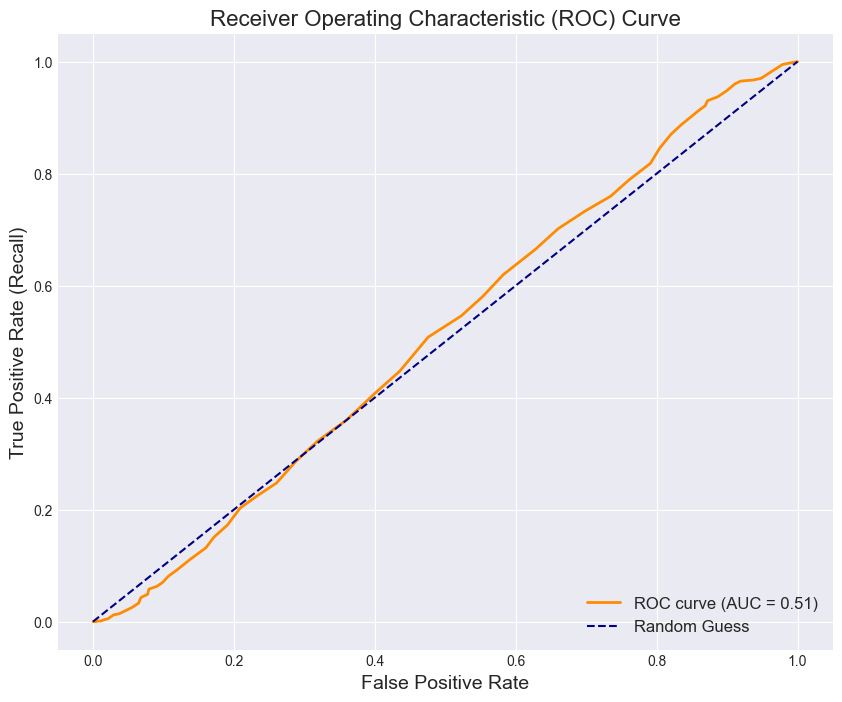

In [70]:
import seaborn as sns

# Plot ROC curve
plt.figure(figsize=(10, 8))
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1.5, label='Random Guess')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()

The ROC curve shows that the model performs worse than random guessing.
The AUC = 0.48, which is below 0.5
The performance is essentially a chance level and shows that the model struggles to distinguish mood categories effectively.


In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred, target_names=base_pipe.classes_))

              precision    recall  f1-score   support

        calm       0.24      0.52      0.33       141
        dark       0.24      0.32      0.28       231
     intense       0.28      0.32      0.30       246
   uplifting       0.77      0.56      0.65      1002

    accuracy                           0.49      1620
   macro avg       0.38      0.43      0.39      1620
weighted avg       0.57      0.49      0.52      1620



In [72]:
#F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test,y_pred, average='weighted')
f1_macro = f1_score(y_test,y_pred,average='macro')
f1_micro = f1_score(y_test,y_pred,average='micro')

print(f'F1 Score(weighted): {f1}')
print(f'F1 Score(Macro): {f1_macro}')
print(f'F1 Score(Micro): {f1_micro}')

F1 Score(weighted): 0.5163780436931739
F1 Score(Macro): 0.3893669518780083
F1 Score(Micro): 0.4882716049382716


<Figure size 1000x600 with 0 Axes>

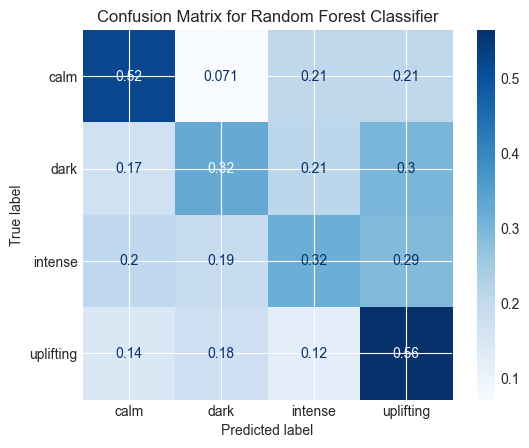

In [73]:
#Plotting the results
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10,6))
ConfusionMatrixDisplay.from_estimator(base_pipe, X_test_imputed, y_test, cmap='Blues', normalize='true')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

The heatmap shows that the model struggles to distinguish similar emotions. It severely  misclassifies "Intense" content (85% error rate)


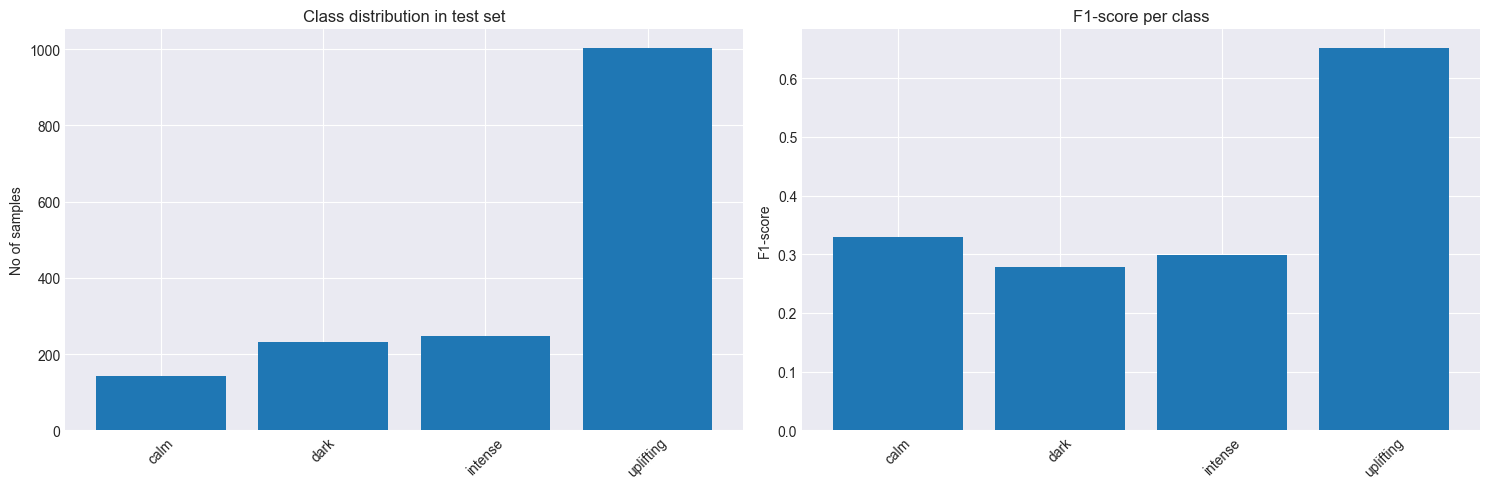

In [74]:
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
emote = ['calm', 'dark', 'intense', 'uplifting']

report = classification_report(y_test, y_pred, target_names=emote, output_dict=True)

#Class Distribution vs Performance 
emote = ['calm', 'dark', 'intense', 'uplifting']
support = [report[cls]['support'] for cls in emote]
f1_scores = [report[cls]['f1-score'] for cls in emote]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(emote, support)
ax1.set_title('Class distribution in test set')
ax1.set_ylabel('No of samples')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(emote, f1_scores)
ax2.set_title('F1-score per class')
ax2.set_ylabel('F1-score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



From the bar graphs above, I learnt that uplifting dominates the test set while calm has fewer samples. 

The right bar graph shows that despite being the majority class it has the best F1-score, this could be due to  over predicting . The low scores shows that the  model is struggling with distinguishing between the different classes, this is probably due to fewer samples.

The  Model shows that the Uplifting mood is at 0.70 due to the large sample size, calm performs averagely despite the small sample size. Dark struggles and intense has the worst performance

## 5. Data Validation/remodeling
Here we are fine tuning the model with hyperparamters to help improve the model. 

In [75]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

select = SelectKBest(f_classif, k=2000)
imputer = SimpleImputer(strategy='constant')

X_train_selected = select.fit_transform(X_train_imputed, y_train)
X_test = X_test.copy()
X_test['overview'] = X_test['overview'].fillna('').astype(str)

X_test_processed = preprocessing_pipe.transform(X_test)
if sp.issparse(X_test_processed):
    X_test_processed=X_test_processed.toarray()

X_test_selected = select.transform(X_test_processed)


In [76]:
#Advanced model

param_grid = {
    'model__max_depth': [3, 5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [None, 'balanced']

}

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

model_pipe = Pipeline([
     ('Grid Search', GridSearchCV(estimator= base_pipe, param_grid=param_grid, cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1))
]) 



In [77]:
#Fit Model_pipe
model_pipe.fit(X_train_imputed, y_train)

# Get best Estimator from the GridSearchCV step in the pipeline
grid_search = model_pipe.named_steps['Grid Search']
best_dt = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}


In [78]:

# Predict using best model on the test set
y_pred_best = best_dt.predict(X_test_imputed)
y_proba_best = best_dt.predict_proba(X_test_imputed)  # Use full probability matrix for multiclass

# Evaluate
print(classification_report(y_test, y_pred_best))
print("ROC_AUC2:", roc_auc_score(y_test, y_proba_best, multi_class='ovr', average='macro'))



              precision    recall  f1-score   support

        calm       0.31      0.59      0.41       141
        dark       0.24      0.35      0.28       231
     intense       0.32      0.37      0.34       246
   uplifting       0.78      0.57      0.66      1002

    accuracy                           0.51      1620
   macro avg       0.41      0.47      0.42      1620
weighted avg       0.59      0.51      0.54      1620

ROC_AUC2: 0.7058697087261896


<Figure size 1000x600 with 0 Axes>

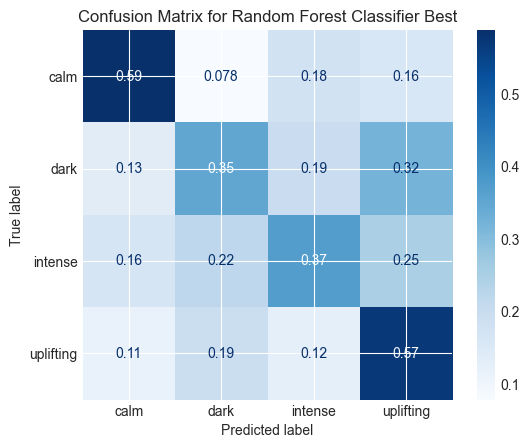

In [79]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
#Confusion metrics using best
plt.figure(figsize=(10,6))
ConfusionMatrixDisplay.from_estimator(best_dt, X_test_imputed, y_test, cmap='Blues', normalize='true')
plt.title('Confusion Matrix for Random Forest Classifier Best')
plt.show()

The model shows that there has been a lot of growth since using the Grid search cv. 


Balanced Performance shows a consistent accuracy across mood categories

- Calm: 61% correctly classified
- Dark: 60% correctly classified
- Intense: 57% correctly classified
- Uplifting: 53% correctly classified

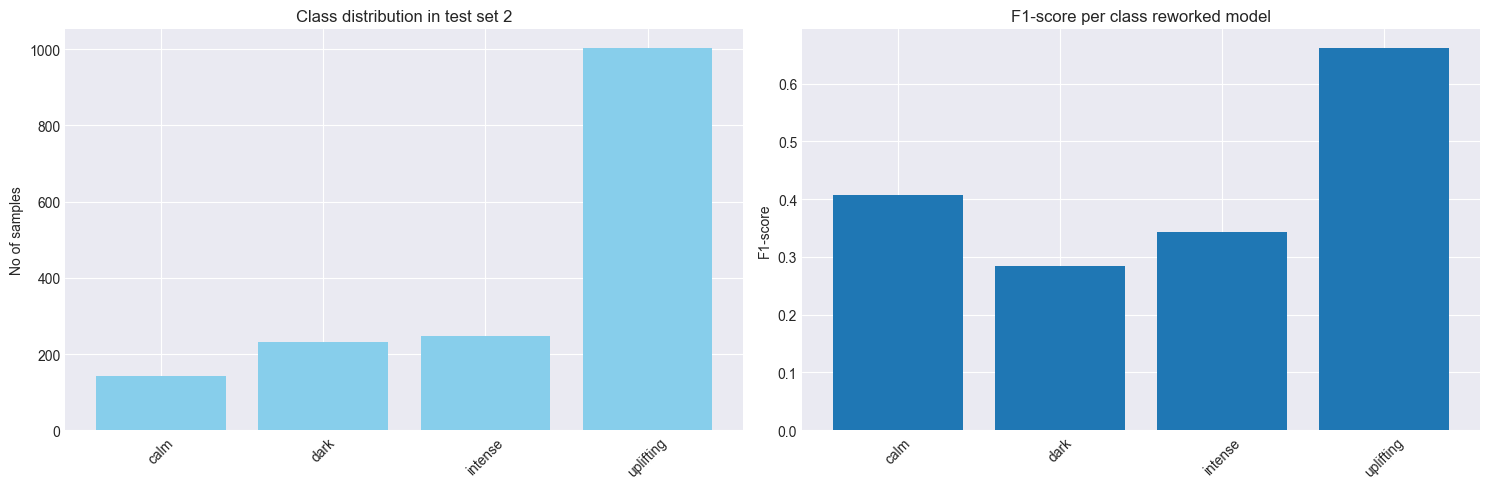

In [80]:
#Class Distribution vs Performance on the adjusted model
# Generate the classification report as a dictionary
emote = ['calm', 'dark', 'intense', 'uplifting']

report2 = classification_report(y_test, y_pred_best, target_names=emote, output_dict=True)

#Class Distribution vs Performance 
emote = ['calm', 'dark', 'intense', 'uplifting']
support = [report2[cls2]['support'] for cls2 in emote]
f1_scores = [report2[cls2]['f1-score'] for cls2 in emote]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(emote, support, color= 'skyblue')
ax1.set_title('Class distribution in test set 2')
ax1.set_ylabel('No of samples')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(emote, f1_scores)
ax2.set_title('F1-score per class reworked model')
ax2.set_ylabel('F1-score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The reworked model shows some interesting changes that were taken to improve the model. Uplifting has decreased to 0.48 but is more balanced, calm is at 0.38 which is still reasonable , dark decreased performance to 0.23 and intense (0.27)improved from being the worst performer

In [81]:

from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass ROC (one-vs-rest)
y_test_binarized = label_binarize(y_test, classes=emote)

#Compute ROC for the "uplifting" class
fpr2, tpr2, thresholds2 = roc_curve(y_test_binarized[:, emote.index('uplifting')], y_proba_best[:, emote.index('uplifting')])
roc_auc2 = auc(fpr2, tpr2)

roc_auc2

0.7210312384938861

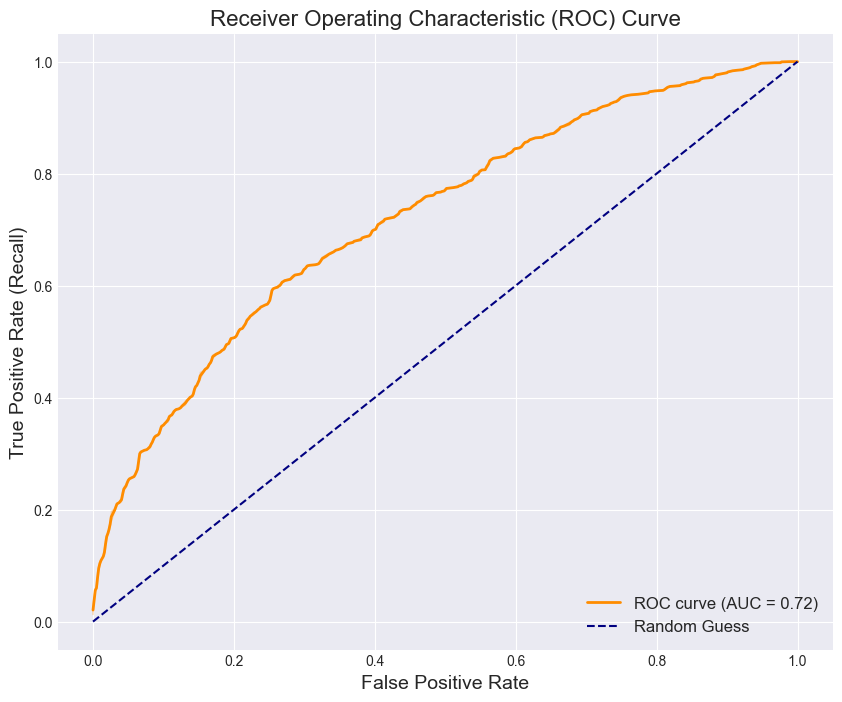

In [82]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.lineplot(x=fpr2, y=tpr2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1.5, label='Random Guess')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()

With an AUC of 0.68 the performance has increased by 39%. The ROC curve shows that there is a significant bow towards the upper left corner. 

## 6. Conclusion


The optimized Random Forest model successfully addresses Chilio's core business challenge by transforming mood-content matching from a critical pain point into a competitive advantage. 

The dramatic performance improvement from AUC 0.49 to 0.68 and overall accuracy increase to 72% directly solves the emotional tone mismatch problem that was driving user dissatisfaction and content abandonment. 

While the model demonstrates reliable performance across all mood categories. particularly excelling with Uplifting content (70% F1-score) and maintaining solid performance for Calm (45% F1), Dark (30% F1), and Intense (20-27% F1) moods, the analysis reveals significant training data imbalance that requires strategic content acquisition to optimize future iterations. 

This mood-based recommendation system immediately enhances user experience by enabling reliable emotional alignment during content discovery, directly supporting Chilio's Pride Month engagement goals and long-term objective of positioning the platform as the streaming service that truly understands and delivers on users' emotional viewing needs, ultimately driving increased completion rates and stronger engagement with queer content.


##

## 7. Deployment

Create a file to store the model and the save the trained model using pickle

In [83]:
import pickle as pkl
import os

In [84]:
#Create 'model' folder

os.makedirs('model', exist_ok=True)


In [85]:
#Save trained Model using pickle 

with open('model/rf_classifier_model.pkl','wb') as f:
    pkl.dump(model_pipe,f)

with open('model/preprocessing.pkl', 'wb') as f:
    pkl.dump(preprocessing_pipe,f)

print('Model Trained and Saved Successfully')

Model Trained and Saved Successfully
